In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

filename = 'final_MLdata.csv'
data = pd.read_csv(filename, header=0, delimiter=",")
clean = data.dropna(subset=['narrative'])

# v = TfidfVectorizer(decode_error='replace', encoding='utf-8')
# x = v.fit_transform(clean.narrative)

train, test = train_test_split(clean, test_size=0.2)

In [83]:
# Extracting features from text files
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train.narrative)
X_train_counts.shape

train['final_category'].value_counts()

ineligible       858
eligible          92
indeterminate     17
Name: final_category, dtype: int64

In [85]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(967, 9045)

In [86]:
# Machine Learning
# Training Naive Bayes (NB) classifier on training data.
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, train.final_category)

In [87]:
# Building a pipeline: We can write less code and do all of the above, by building a pipeline as follows:
# The names ‘vect’ , ‘tfidf’ and ‘clf’ are arbitrary but will be used later.
# We will be using the 'text_clf' going forward.
from sklearn.pipeline import Pipeline

text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

text_clf = text_clf.fit(train.narrative, train.final_category)

In [95]:
# Performance of NB Classifier# Perfor 
import numpy as np
from sklearn.utils import shuffle
predicted = text_clf.predict(test.narrative)
np.mean(predicted == test.final_category)

from sklearn import metrics
metrics.confusion_matrix(test.final_category, predicted)

from sklearn.metrics import classification_report
print ('\nClasification report:\n', classification_report(test.final_category, predicted))
from sklearn.metrics import confusion_matrix
print ('\nConfussion matrix:\n',confusion_matrix(test.final_category, predicted))





Clasification report:
                precision    recall  f1-score   support

     eligible       0.00      0.00      0.00        13
indeterminate       0.00      0.00      0.00         5
   ineligible       0.93      1.00      0.96       224

  avg / total       0.86      0.93      0.89       242


Confussion matrix:
 [[  0   0  13]
 [  0   0   5]
 [  0   0 224]]


C:\Users\rstem15\.atompackages\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([  0.        ,   0.        , 101.40458022])

In [66]:
# Training Support Vector Machines - SVM and calculating its performance
import sklearn
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=5, random_state=0))])

text_clf_svm = text_clf_svm.fit(train.narrative, train.final_category)
predicted_svm = text_clf_svm.predict(test.narrative)
np.mean(predicted_svm == test.final_category)

from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(test.final_category, predicted_svm)

from sklearn.metrics import classification_report
print ('\nClasification report:\n', classification_report(test.final_category, predicted_svm))
from sklearn.metrics import confusion_matrix
print ('\nConfussion matrix:\n',confusion_matrix(test.final_category, predicted_svm))



Clasification report:
                precision    recall  f1-score   support

     eligible       0.86      0.46      0.60        13
indeterminate       0.00      0.00      0.00         5
   ineligible       0.95      1.00      0.97       224

  avg / total       0.92      0.95      0.93       242


Confussion matrix:
 [[  6   0   7]
 [  0   0   5]
 [  1   0 223]]


C:\Users\rstem15\.atompackages\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [67]:
# Grid Search
# Here, we are creating a list of parameters for which we would like to do performance tuning. 
# All the parameters name start with the classifier name (remember the arbitrary name we gave). 
# E.g. vect__ngram_range; here we are telling to use unigram and bigrams and choose the one which is optimal.

from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1e-2, 1e-3)}

# Next, we create an instance of the grid search by passing the classifier, parameters # Next,  
# and n_jobs=-1 which tells to use multiple cores from user machine.

gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(train.narrative, train.final_category)

In [68]:
# To see the best mean score and the params, run the following code# To see 

gs_clf.best_score_
gs_clf.best_params_

# Output for above should be: The accuracy has now increased to ~90.6% for the NB classifier (not so naive anymore! 😄)
# and the corresponding parameters are {‘clf__alpha’: 0.01, ‘tfidf__use_idf’: True, ‘vect__ngram_range’: (1, 2)}.

{'clf__alpha': 0.01, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

In [69]:
# NLTK
# Removing stop words
from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english')), ('tfidf', TfidfTransformer()), 
                     ('clf', MultinomialNB())])

In [70]:
# Stemming Code

import nltk

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
    
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')

text_mnb_stemmed = Pipeline([('vect', stemmed_count_vect), ('tfidf', TfidfTransformer()), 
                             ('mnb', MultinomialNB(fit_prior=False))])

text_mnb_stemmed = text_mnb_stemmed.fit(train.narrative, train.final_category)

predicted_mnb_stemmed = text_mnb_stemmed.predict(test.narrative)

np.mean(predicted_mnb_stemmed == test.final_category)

from sklearn import metrics
metrics.confusion_matrix(test.final_category, predicted_mnb_stemmed)

from sklearn.metrics import classification_report
print ('\nClasification report:\n', classification_report(test.final_category, predicted_mnb_stemmed))


Clasification report:
                precision    recall  f1-score   support

     eligible       0.00      0.00      0.00        13
indeterminate       0.00      0.00      0.00         5
   ineligible       0.93      1.00      0.96       224

  avg / total       0.86      0.93      0.89       242



C:\Users\rstem15\.atompackages\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [104]:
# Training Support Vector Machines - SVM and calculating its performance
import sklearn
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=5, random_state=0))])

text_clf_svm = text_clf_svm.fit(train.narrative, train.final_category)
predicted_svm = text_clf_svm.predict(test.narrative)
np.mean(predicted_svm == test.final_category)

from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(test.final_category, predicted_svm)

from sklearn.metrics import classification_report
print ('\nClasification report:\n', classification_report(test.final_category, predicted_svm))

FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
print('FP:',FP)
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
print('FN:',FN)
TP = np.diag(confusion_matrix)
print('TP:',TP)
TN = confusion_matrix.sum() - (FP + FN + TP)
print('TN:',TN)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print('sensitivity:', TPR)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print('specificity:', TNR)
# Precision or positive predictive value
PPV = TP/(TP+FP)
print('PPV:', PPV)
# Negative predictive value
NPV = TN/(TN+FN)
print('NPV', NPV)
# Fall out or false positive rate
FPR = FP/(FP+TN)
print('false positive rate:', FPR)
# False negative rate
FNR = FN/(TP+FN)
print('False negative rate:', FNR)
# False discovery rate
FDR = FP/(TP+FP)
print('false discovery rate:', FDR)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print('overall accuracy:', ACC)


Clasification report:
                precision    recall  f1-score   support

     eligible       0.86      0.46      0.60        13
indeterminate       0.00      0.00      0.00         5
   ineligible       0.95      1.00      0.97       224

  avg / total       0.92      0.95      0.93       242

FP: [ 1  0 12]
FN: [7 5 1]
TP: [  6   0 223]
TN: [228 237   6]
sensitivity: [0.46153846 0.         0.99553571]
specificity: [0.99563319 1.         0.33333333]
PPV: [0.85714286        nan 0.94893617]
NPV [0.97021277 0.97933884 0.85714286]
false positive rate: [0.00436681 0.         0.66666667]
False negative rate: [0.53846154 1.         0.00446429]
false discovery rate: [0.14285714        nan 0.05106383]
overall accuracy: [0.96694215 0.97933884 0.94628099]


C:\Users\rstem15\.atompackages\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rstem15\.atompackages\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
C:\Users\rstem15\.atompackages\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide


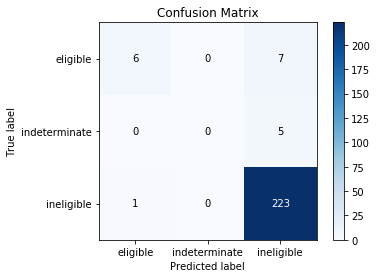

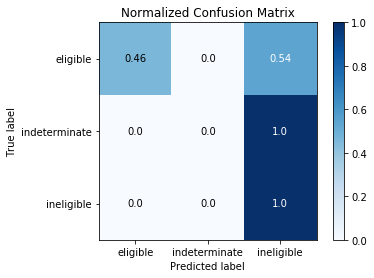

In [114]:
import matplotlib.pyplot as plt 
import scikitplot as skplt 
skplt.metrics.plot_confusion_matrix(test.final_category, predicted_svm)
plt.show()

skplt.metrics.plot_confusion_matrix(test.final_category, predicted_svm, normalize=True)
plt.show()

0.9256198347107438

Clasification report:
                precision    recall  f1-score   support

     eligible       0.71      0.77      0.74        13
indeterminate       0.00      0.00      0.00         5
   ineligible       0.98      0.96      0.97       224

  avg / total       0.94      0.93      0.93       242

FP: [4 9 5]
FN: [ 3  5 10]
TP: [ 10   0 214]
TN: [225 228  13]
sensitivity: [0.76923077 0.         0.95535714]
specificity: [0.98253275 0.96202532 0.72222222]
PPV: [0.71428571 0.         0.97716895]
NPV [0.98684211 0.97854077 0.56521739]
false positive rate: [0.01746725 0.03797468 0.27777778]
False negative rate: [0.23076923 1.         0.04464286]
false discovery rate: [0.28571429 1.         0.02283105]
overall accuracy: [0.97107438 0.94214876 0.93801653]


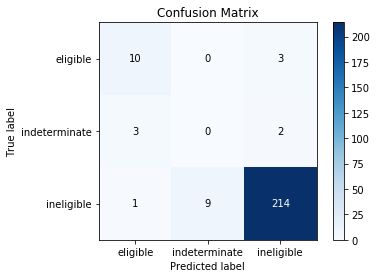

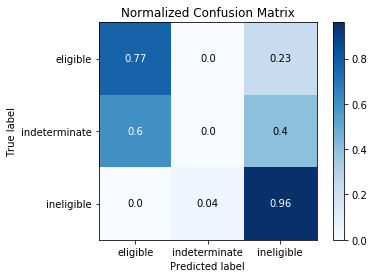

In [113]:
# GBT
import sklearn
from sklearn.ensemble import GradientBoostingClassifier

logistic = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                         ('clf-logistic', GradientBoostingClassifier(max_depth=1, n_estimators=100, learning_rate=1.0))])

text_clf_logistic = logistic.fit(train.narrative, train.final_category)
predicted_logistic = logistic.predict(test.narrative)
print(np.mean(predicted_logistic == test.final_category))

from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(test.final_category, predicted_logistic)

from sklearn.metrics import classification_report
print ('\nClasification report:\n', classification_report(test.final_category, predicted_logistic))

FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
print('FP:',FP)
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
print('FN:',FN)
TP = np.diag(confusion_matrix)
print('TP:',TP)
TN = confusion_matrix.sum() - (FP + FN + TP)
print('TN:',TN)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print('sensitivity:', TPR)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print('specificity:', TNR)
# Precision or positive predictive value
PPV = TP/(TP+FP)
print('PPV:', PPV)
# Negative predictive value
NPV = TN/(TN+FN)
print('NPV', NPV)
# Fall out or false positive rate
FPR = FP/(FP+TN)
print('false positive rate:', FPR)
# False negative rate
FNR = FN/(TP+FN)
print('False negative rate:', FNR)
# False discovery rate
FDR = FP/(TP+FP)
print('false discovery rate:', FDR)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print('overall accuracy:', ACC)

import matplotlib.pyplot as plt 
import scikitplot as skplt 
skplt.metrics.plot_confusion_matrix(test.final_category, predicted_logistic)
plt.show()

skplt.metrics.plot_confusion_matrix(test.final_category, predicted_logistic, normalize=True)
plt.show()

0.9256198347107438

Clasification report:
                precision    recall  f1-score   support

     eligible       0.00      0.00      0.00        13
indeterminate       0.00      0.00      0.00         5
   ineligible       0.93      1.00      0.96       224

  avg / total       0.86      0.93      0.89       242

FP: [ 0  0 18]
FN: [13  5  0]
TP: [  0   0 224]
TN: [229 237   0]
sensitivity: [0. 0. 1.]
specificity: [1. 1. 0.]
PPV: [       nan        nan 0.92561983]
NPV [0.94628099 0.97933884        nan]
false positive rate: [0. 0. 1.]
False negative rate: [1. 1. 0.]
false discovery rate: [       nan        nan 0.07438017]
overall accuracy: [0.94628099 0.97933884 0.92561983]


C:\Users\rstem15\.atompackages\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\rstem15\.atompackages\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
C:\Users\rstem15\.atompackages\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide
C:\Users\rstem15\.atompackages\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


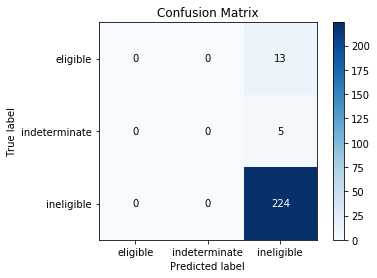

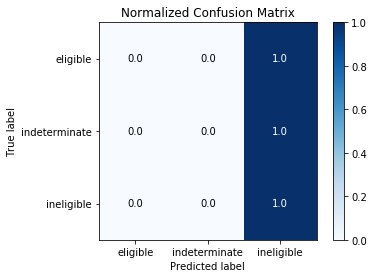

In [112]:
# Random forest 
import sklearn
from sklearn.ensemble import RandomForestClassifier

text_clf_randomforest = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                         ('clf-randomforest', RandomForestClassifier(bootstrap=True, max_depth=2, max_features='auto', n_estimators=100))])

text_clf_randomforest = text_clf_randomforest.fit(train.narrative, train.final_category)
predicted_randomforest = text_clf_randomforest.predict(test.narrative)
print(np.mean(predicted_randomforest == test.final_category))

from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(test.final_category, predicted_randomforest)

from sklearn.metrics import classification_report
print ('\nClasification report:\n', classification_report(test.final_category, predicted_randomforest))

FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
print('FP:',FP)
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
print('FN:',FN)
TP = np.diag(confusion_matrix)
print('TP:',TP)
TN = confusion_matrix.sum() - (FP + FN + TP)
print('TN:',TN)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print('sensitivity:', TPR)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print('specificity:', TNR)
# Precision or positive predictive value
PPV = TP/(TP+FP)
print('PPV:', PPV)
# Negative predictive value
NPV = TN/(TN+FN)
print('NPV', NPV)
# Fall out or false positive rate
FPR = FP/(FP+TN)
print('false positive rate:', FPR)
# False negative rate
FNR = FN/(TP+FN)
print('False negative rate:', FNR)
# False discovery rate
FDR = FP/(TP+FP)
print('false discovery rate:', FDR)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print('overall accuracy:', ACC)

import matplotlib.pyplot as plt 
import scikitplot as skplt 
skplt.metrics.plot_confusion_matrix(test.final_category, predicted_randomforest)
plt.show()

skplt.metrics.plot_confusion_matrix(test.final_category, predicted_randomforest, normalize=True)
plt.show()

In [103]:
# AdaBoost Classifier
import sklearn
from sklearn.ensemble import AdaBoostClassifier

text_clf_randomforest = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                         ('clf-randomforest', AdaBoostClassifier(base_estimator=None, n_estimators=100))])

text_clf_randomforest = text_clf_randomforest.fit(train.narrative, train.final_category)
predicted_adaboost= text_clf_randomforest.predict(test.narrative)
print(np.mean(predicted_adaboost == test.final_category))

from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(test.final_category, predicted_adaboost)

from sklearn.metrics import classification_report
print ('\nClasification report:\n', classification_report(test.final_category, predicted_adaboost))

FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
print('FP:',FP)
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
print('FN:',FN)
TP = np.diag(confusion_matrix)
print('TP:',TP)
TN = confusion_matrix.sum() - (FP + FN + TP)
print('TN:',TN)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print('sensitivity:', TPR)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
print('specificity:', TNR)
# Precision or positive predictive value
PPV = TP/(TP+FP)
print('PPV:', PPV)
# Negative predictive value
NPV = TN/(TN+FN)
print('NPV', NPV)
# Fall out or false positive rate
FPR = FP/(FP+TN)
print('false positive rate:', FPR)
# False negative rate
FNR = FN/(TP+FN)
print('False negative rate:', FNR)
# False discovery rate
FDR = FP/(TP+FP)
print('false discovery rate:', FDR)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print('overall accuracy:', ACC)

0.9421487603305785

Clasification report:
                precision    recall  f1-score   support

     eligible       1.00      0.38      0.56        13
indeterminate       0.00      0.00      0.00         5
   ineligible       0.94      1.00      0.97       224

  avg / total       0.93      0.94      0.93       242

FP: [ 0  1 13]
FN: [8 5 1]
TP: [  5   0 223]
TN: [229 236   5]
sensitivity: [0.38461538 0.         0.99553571]
specificity: [1.         0.99578059 0.27777778]
PPV: [1.         0.         0.94491525]
NPV [0.96624473 0.97925311 0.83333333]
false positive rate: [0.         0.00421941 0.72222222]
False negative rate: [0.61538462 1.         0.00446429]
false discovery rate: [0.         1.         0.05508475]
overall accuracy: [0.96694215 0.97520661 0.94214876]


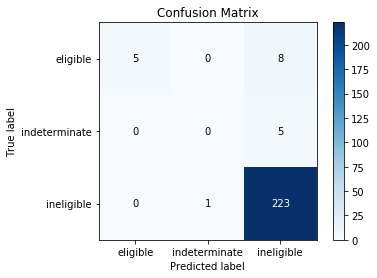

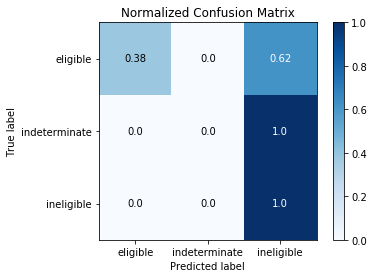

In [111]:
import matplotlib.pyplot as plt 
import scikitplot as skplt 
skplt.metrics.plot_confusion_matrix(test.final_category, predicted_adaboost)
plt.show()

skplt.metrics.plot_confusion_matrix(test.final_category, predicted_adaboost, normalize=True)
plt.show()

In [107]:
test['final_category'].value_counts()

ineligible       224
eligible          13
indeterminate      5
Name: final_category, dtype: int64